# Library

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras import Model, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Input, Dot, Flatten, Dense
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import keras
import warnings
warnings.filterwarnings("ignore")

# Untuk tampilan visual yang lebih menarik
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Data Understanding

In [22]:
# Baca data
df_movies = pd.read_csv('/content/movies.csv')
df_ratings = pd.read_csv('/content/ratings.csv')
df_tags = pd.read_csv('/content/tags.csv')

# Gabungkan tag berdasarkan userId dan movieId
df_tags_grouped = df_tags.groupby(['userId', 'movieId'])['tag'].agg(lambda x: ' '.join(x)).reset_index()

# Merge movies dan ratings dan tags berdasarkan 'movieId'
df_temp = pd.merge(df_ratings, df_movies, on='movieId')
df = pd.merge(df_temp, df_tags_grouped, on=['userId', 'movieId'], how='left')

# Lihat hasil akhir
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (100836, 7)


,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
 6   tag        1635 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 5.4+ MB


In [24]:
# cek duplikat
print("Jumlah duplikat: ", df.duplicated().sum())

Jumlah duplikat:  0


In [25]:
# cek missing value
print("Jumlah missing value: ")
print(df.isnull().sum())

Jumlah missing value: 
userId           0
movieId          0
rating           0
timestamp        0
title            0
genres           0
tag          99201
dtype: int64


In [10]:
# Statistik deskriptif
df.describe().T.style.background_gradient(cmap='YlGnBu').format(precision=2)

,count,mean,std,min,25%,50%,75%,max
userId,100836.00,326.13,182.62,1.00,177.00,325.00,477.00,610.00
movieId,100836.00,19435.30,35530.99,1.00,1199.00,2991.00,8122.00,193609.00
rating,100836.00,3.50,1.04,0.50,3.00,3.50,4.00,5.00
timestamp,100836.00,1205946087.37,216261036.00,828124615.00,1019123866.00,1186086662.00,1435994144.50,1537799250.00


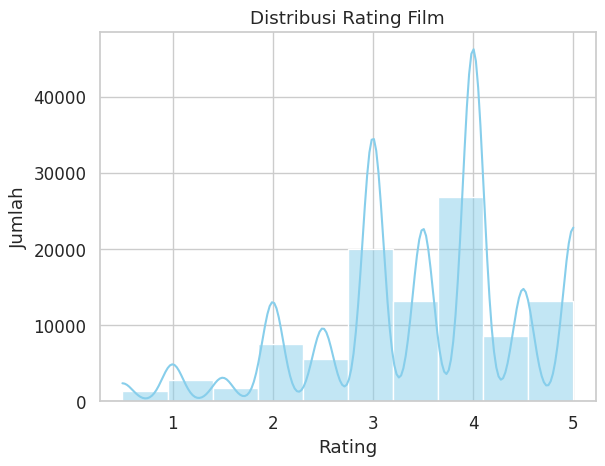

In [11]:
# --- Distribusi Rating ---
sns.histplot(df['rating'], bins=10, kde=True, color='skyblue')
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Gambar di atas memperlihatkan sebaran rating yang diberikan pengguna terhadap film di dalam dataset. Terlihat bahwa mayoritas pengguna cenderung memberikan rating pada skala menengah hingga tinggi, khususnya di angka 4 dan 5. Hal ini menunjukkan adanya bias positif dalam proses evaluasi, yang merupakan fenomena umum dalam sistem rating terbuka, di mana pengguna cenderung hanya memberikan penilaian terhadap film yang mereka sukai atau telah mereka pilih secara selektif.

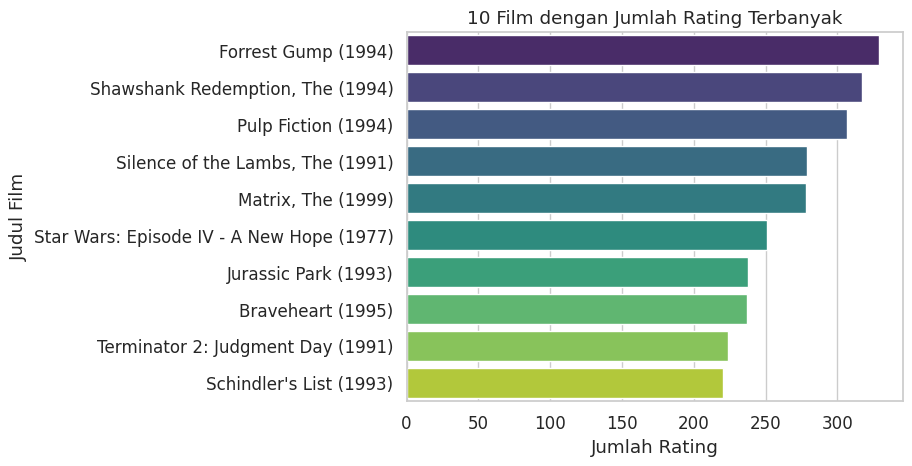

In [12]:
# --- Film Paling Banyak Di-rating ---
top_movies = df['title'].value_counts().head(10)
sns.barplot(y=top_movies.index, x=top_movies.values, palette='viridis')
plt.title('10 Film dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
plt.show()

Visualisasi di atas menunjukkan sepuluh film dengan jumlah rating terbanyak dari pengguna dalam dataset sistem rekomendasi film. Film dengan rating terbanyak adalah Forrest Gump (1994) dengan 329 rating, diikuti oleh The Shawshank Redemption (1994) dan Pulp Fiction (1994) dengan masing-masing 317 dan 307 rating. Sebagian besar film yang masuk dalam daftar ini merupakan film klasik dari era 1990-an, yang menandakan adanya kecenderungan pengguna untuk memberikan rating terhadap film-film ikonik atau yang memiliki nilai nostalgia tinggi.

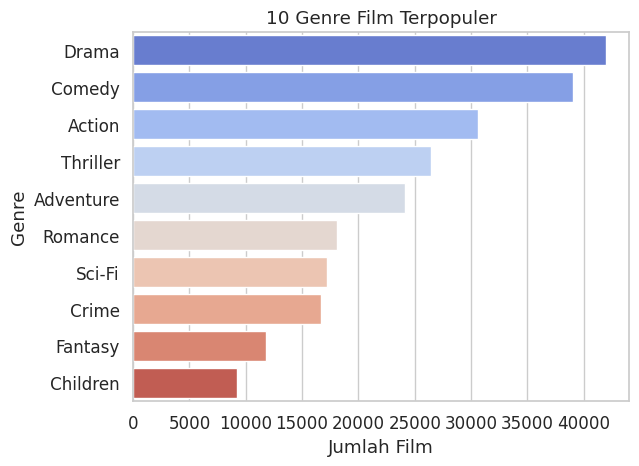

In [13]:
# --- Genre Paling Umum ---
# Pisahkan genre karena bisa lebih dari satu per film
genre_list = df['genres'].dropna().str.split('|').explode()
top_genres = genre_list.value_counts().head(10)

sns.barplot(x=top_genres.values, y=top_genres.index, palette='coolwarm')
plt.title('10 Genre Film Terpopuler')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.show()

Bar chart ini menunjukkan distribusi sepuluh genre film yang paling banyak muncul berdasarkan jumlah rating yang tercatat dalam dataset. Genre Drama merupakan yang paling dominan dengan total 41.928 entri, diikuti oleh Comedy (39.053), Action (30.635), dan Thriller (26.452). Urutan ini mencerminkan kecenderungan pengguna untuk lebih banyak menonton dan memberi rating pada film-film dengan narasi kuat atau hiburan populer. Genre Adventure, Romance, dan Sci-Fi juga memiliki jumlah signifikan, menandakan bahwa variasi tema menjadi faktor penting dalam konsumsi film. Di sisi lain, genre seperti Fantasy (11.834) dan Children (9.208) menunjukkan keterwakilan yang lebih rendah, yang bisa jadi disebabkan oleh segmentasi usia pengguna atau keterbatasan dalam ketersediaan konten genre tersebut dalam dataset.

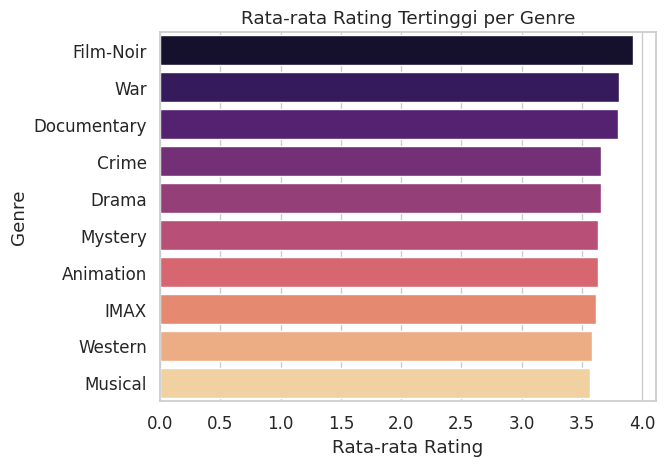

In [14]:
# --- Rata-rata Rating per Genre ---
genre_ratings = df.copy()
genre_ratings['genre'] = genre_ratings['genres'].str.split('|')
genre_ratings = genre_ratings.explode('genre')

avg_genre_rating = genre_ratings.groupby('genre')['rating'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=avg_genre_rating.values, y=avg_genre_rating.index, palette='magma')
plt.title('Rata-rata Rating Tertinggi per Genre')
plt.xlabel('Rata-rata Rating')
plt.ylabel('Genre')
plt.show()

Bar chart ini menunjukkan sepuluh genre film dengan rata-rata rating tertinggi dalam dataset. Genre Film-Noir berada di peringkat pertama dengan nilai rata-rata sebesar 3,92, disusul oleh War (3,81) dan Documentary (3,80), yang menunjukkan bahwa film dalam genre-genre ini cenderung mendapat apresiasi lebih tinggi dari pengguna. Meskipun tidak selalu menjadi genre dengan jumlah penilaian terbanyak, tingginya rata-rata ini mengindikasikan adanya persepsi kualitas atau nilai artistik yang lebih kuat pada genre-genre tersebut. Genre seperti Crime dan Drama yang lebih umum juga masuk dalam daftar, sementara genre yang lebih spesifik seperti IMAX dan Western menunjukkan kualitas yang relatif tinggi meskipun tidak terlalu dominan secara kuantitatif.

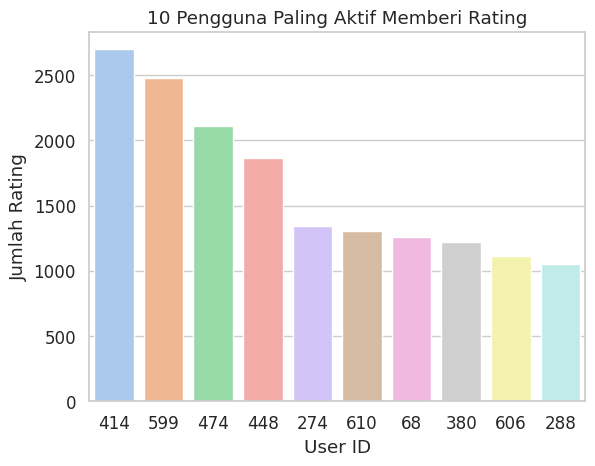

In [15]:
# --- Pengguna Paling Aktif ---
top_users = df['userId'].value_counts().head(10)
sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette='pastel')
plt.title('10 Pengguna Paling Aktif Memberi Rating')
plt.xlabel('User ID')
plt.ylabel('Jumlah Rating')
plt.show()

Bar chart ini menampilkan sepuluh pengguna dengan jumlah rating terbanyak dalam dataset, yang menunjukkan tingkat aktivitas individu dalam memberikan evaluasi terhadap film. Pengguna dengan ID 414 tercatat sebagai yang paling aktif dengan total 2.698 rating, disusul oleh ID 599 (2.478 rating) dan ID 474 (2.108 rating). Seluruh pengguna dalam daftar ini telah memberikan lebih dari seribu rating, menunjukkan konsistensi dan keterlibatan tinggi dalam interaksi dengan data film. Pola ini mencerminkan adanya sekelompok kecil pengguna yang berkontribusi secara signifikan terhadap volume data, yang umum ditemukan dalam distribusi partisipasi berbasis pengguna, di mana sebagian besar kontribusi berasal dari minoritas pengguna yang sangat akti

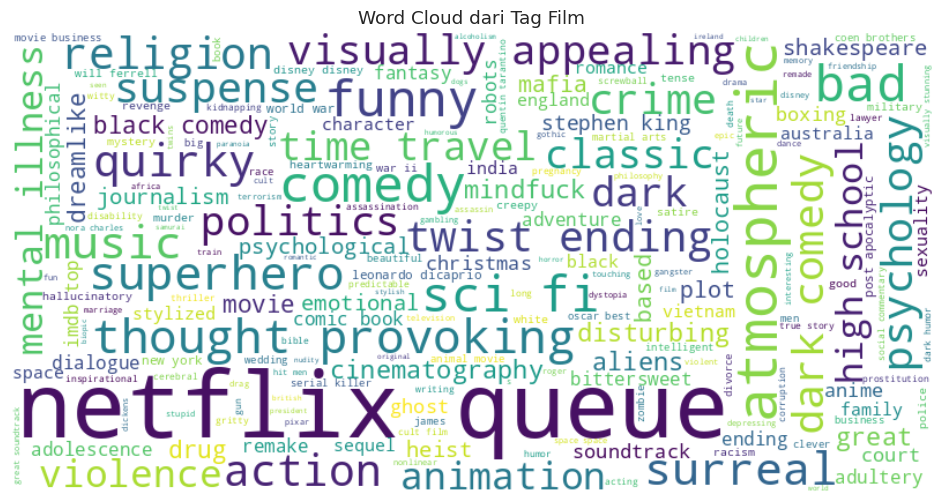

In [17]:
# --- WordCloud dari Tag ---
tags = df_tags  ['tag'].dropna().str.lower().str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Tag Film')
plt.show()

Word cloud ini merepresentasikan kata-kata kunci atau tag yang paling sering diasosiasikan dengan film dalam dataset, di mana ukuran kata mencerminkan frekuensi kemunculannya. Tag seperti netflix queue, thought provoking, superhero, sci-fi, dan comedy muncul dalam ukuran besar, menunjukkan bahwa tema-tema tersebut sering digunakan untuk mendeskripsikan atau mengkategorikan film. Kehadiran kata-kata seperti surreal, psychology, mental illness, dan dark comedy mengindikasikan adanya preferensi pengguna terhadap film-film dengan tema kompleks, atmosferik, atau emosional. Di sisi lain, tag seperti high school, time travel, dan action menunjukkan keberagaman dalam genre dan konteks cerita.

# Data Preprocessing

## Content Based Filtering

In [26]:
# Gabungkan genre + tag jadi fitur konten
df['tag'] = df['tag'].fillna('')
df['content'] = df['genres'].fillna('') + ' ' + df['tag']

In [39]:
# Ambil satu baris per film
df_content = df.groupby('movieId').agg({
    'title': 'first',
    'content': lambda x: ' '.join(x)
}).reset_index()

df_content = pd.merge(df_content, df_movies[['movieId', 'genres']], on='movieId', how='left')

In [40]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_content['content'])

# Hitung similarity antar film
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## Collaborative Filtering

In [50]:
# Encode userId dan movieId
user_enc = LabelEncoder()
movie_enc = LabelEncoder()
df_cf = df[['userId', 'movieId', 'rating']].dropna().copy()
df_cf['user'] = user_enc.fit_transform(df_cf['userId'])
df_cf['movie'] = movie_enc.fit_transform(df_cf['movieId'])

In [53]:
# Collect sum unique user and movie
n_users = df_cf['user'].nunique()
n_movies = df_cf['movie'].nunique()

In [55]:
# Train-test split
X = df_cf[['user', 'movie']]
y = df_cf['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Scaling data
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Modelling and Result

## Content Based Filtering

In [109]:
# Fungsi CBF
def recommend_for_user_content_based(title, df=df_content, similarity=cosine_sim, top_n=5):
    idx = df[df['title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        return "Film tidak ditemukan."

    idx = idx[0]
    input_title = df.iloc[idx]['title']
    input_genre = df.iloc[idx]['genres'].replace('|', ', ')

    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    recommendations = df.iloc[movie_indices][['title', 'genres']].reset_index(drop=True)
    recommendations['genres'] = recommendations['genres'].str.replace('|', ', ', regex=False)

    # Mengembalikan hasil rekomendasi
    return recommendations, input_title, input_genre

In [110]:
# Memanggil fungsi dan mendapatkan hasil rekomendasi
recommendations, input_title, input_genre = recommend_for_user_content_based("Jumanji (1995)", top_n=5)

# Print hasilnya di luar fungsi
if isinstance(recommendations, str):  # Jika hasilnya error (film tidak ditemukan)
    print(recommendations)
else:
    print(f"🎬 Judul yang Dicari: {input_title}")
    print(f"🎭 Genre: {input_genre}\n")
    print(f"🔝 Top {len(recommendations)} Rekomendasi dari \"{input_title}\":")

    for i, row in recommendations.iterrows():
        print(f"{i+1}. {row['title']} - Genre: {row['genres']}")

🎬 Judul yang Dicari: Jumanji (1995)
🎭 Genre: Adventure, Children, Fantasy

🔝 Top 5 Rekomendasi dari "Jumanji (1995)":
1. Indian in the Cupboard, The (1995) - Genre: Adventure, Children, Fantasy
2. NeverEnding Story III, The (1994) - Genre: Adventure, Children, Fantasy
3. Escape to Witch Mountain (1975) - Genre: Adventure, Children, Fantasy
4. Darby O'Gill and the Little People (1959) - Genre: Adventure, Children, Fantasy
5. Return to Oz (1985) - Genre: Adventure, Children, Fantasy


## Collaborative Filtering

In [58]:
# Model Rekomendasi dengan Embedding Layer
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        # Layer embedding untuk user
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)  # Bias untuk user

        # Layer embedding untuk item (lagu)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.item_bias = layers.Embedding(num_items, 1)  # Bias untuk item

    def call(self, inputs):
        # Ambil embedding user dan item
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        # Hitung dot product antara embedding user dan item
        dot_user_item = tf.tensordot(user_vector, item_vector, axes=2)

        # Menambahkan bias
        x = dot_user_item + user_bias + item_bias

        # Sigmoid activation untuk output (probabilitas)
        return tf.nn.sigmoid(x)

# Inisialisasi model
model = RecommenderNet(n_users, n_movies, 50)

# Compile model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [59]:
# Callback EarlyStopping dengan pemberitahuan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fungsi custom untuk pemberitahuan jika training berhenti
class PrintStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            print(f"\nTraining dihentikan pada epoch {epoch + 1}, karena tidak ada perbaikan pada 'val_loss'.")

# Gabungkan callback untuk pemberitahuan dan EarlyStopping
callbacks = [early_stopping, PrintStopping()]

In [61]:
# Training model dengan callback
history = model.fit(
    X_train, y_train_scaled,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test_scaled),
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0490 - root_mean_squared_error: 0.2202 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2166
Epoch 2/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0435 - root_mean_squared_error: 0.2071 - val_loss: 0.0452 - val_root_mean_squared_error: 0.2107
Epoch 3/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0427 - root_mean_squared_error: 0.2047 - val_loss: 0.0442 - val_root_mean_squared_error: 0.2078
Epoch 4/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0418 - root_mean_squared_error: 0.2020 - val_loss: 0.0438 - val_root_mean_squared_error: 0.2065
Epoch 5/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0415 - root_mean_squared_error: 0.2008 - val_loss: 0.0433 - val_root_mean_squared_error: 0.2049
Epoch 6/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0408 - root_mean_squared_error: 0.1988 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2045
Epoch 7/100
1261/1261 ━━━━━

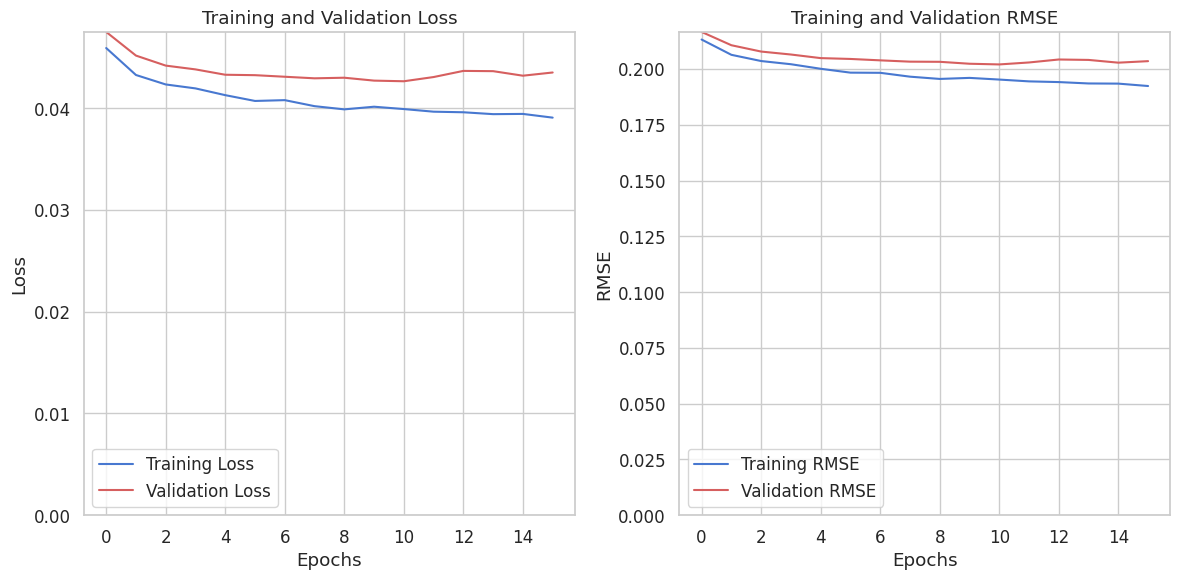

In [63]:
# Plotting Loss dan RMSE
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))  # Batas Y mulai dari 0

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE', color='b')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE', color='r')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.ylim(0, max(max(history.history['root_mean_squared_error']), max(history.history['val_root_mean_squared_error'])))  # Batas Y mulai dari 0

plt.tight_layout()
plt.show()

In [67]:
# Evaluasi
test_loss, test_rmse = model.evaluate(X_test.values, y_test_scaled)
print(f"Test RMSE: {test_rmse:.4f}")


631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0440 - root_mean_squared_error: 0.2055
Test RMSE: 0.2044


In [107]:
# Fungsi rekomendasi film untuk user tertentu
def recommend_for_user_collaborative(user_raw_id, top_n=5):
    user_id = user_enc.transform([user_raw_id])[0]

    # Film yang sudah ditonton user dan ratingnya
    watched_movies = df_cf[df_cf['user'] == user_id][['movie', 'rating']].sort_values(by='rating', ascending=False)

    # Top 5 film yang sudah ditonton berdasarkan rating
    top_watched = watched_movies.head(top_n).reset_index(drop=True)  # Reset index

    # Film yang belum ditonton oleh user
    watched_movie_ids = watched_movies['movie'].tolist()
    all_movie_ids = np.setdiff1d(np.arange(n_movies), watched_movie_ids)

    user_input = np.array([[user_id, mid] for mid in all_movie_ids])
    predictions = model.predict(user_input).flatten()
    top_indices = predictions.argsort()[-top_n:][::-1]
    recommended_movie_ids = all_movie_ids[top_indices]
    recommended_titles = movie_enc.inverse_transform(recommended_movie_ids)

    # Kembalikan hasil rekomendasi dan top watched
    recommended_movies = df_movies[df_movies['movieId'].isin(recommended_titles)][['title', 'genres']]

    return top_watched, recommended_movies

In [108]:
# Pilih user ID secara acak dari data rating
random_user = random.choice(df_cf['user'].unique())
user_raw_id = user_enc.inverse_transform([random_user])[0]

# Panggil fungsi rekomendasi
top_watched, recommended_movies = recommend_for_user_collaborative(user_raw_id, top_n=5)

# Print top watched movies
print(f"🎬 Top 5 Film yang Sudah Ditonton oleh User {user_raw_id}:")
top_watched = top_watched.reset_index(drop=True)
for i, row in top_watched.iterrows():
    movie_id = int(row['movie'])  # pastikan tipe datanya integer
    movie_row = df_movies[df_movies['movieId'] == movie_id]
    if not movie_row.empty:
        movie_title = movie_row['title'].values[0]
        movie_genre = movie_row['genres'].values[0].replace('|', ', ')
        print(f"{i+1}. {movie_title} - Genre: {movie_genre} - Rating: {row['rating']}")
    else:
        print(f"{i+1}. Movie ID {movie_id} not found in movie list.")

# Print recommended movies
recommended_movies = recommended_movies.reset_index(drop=True)
print(f"\n🔝 Top 5 Rekomendasi dari User {user_raw_id}:")
for i, row in recommended_movies.iterrows():
    genre = row['genres'].replace('|', ', ')
    print(f"{i+1}. {row['title']} - Genre: {genre}")


298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🎬 Top 5 Film yang Sudah Ditonton oleh User 522:
1. Safe (1995) - Genre: Thriller - Rating: 5.0
2. Miracle on 34th Street (1994) - Genre: Drama - Rating: 5.0
3. Night of the Living Dead (1968) - Genre: Horror, Sci-Fi, Thriller - Rating: 5.0
4. Kissed (1996) - Genre: Drama, Romance - Rating: 5.0
5. My Fair Lady (1964) - Genre: Comedy, Drama, Musical, Romance - Rating: 5.0

🔝 Top 5 Rekomendasi dari User 522:
1. Rear Window (1954) - Genre: Mystery, Thriller
2. Casablanca (1942) - Genre: Drama, Romance
3. Hamlet (1996) - Genre: Crime, Drama, Romance
4. Prestige, The (2006) - Genre: Drama, Mystery, Sci-Fi, Thriller
5. Logan (2017) - Genre: Action, Sci-Fi


# Evaluation

## Content Based Filtering

In [143]:
# Fungsi ubah genre ke str
def genre_to_set(genre_str):
    # Pastikan genre_str adalah list, kalau bukan, ubah ke list
    if isinstance(genre_str, str):
        return set(genre_str.lower().split(', '))
    elif isinstance(genre_str, list):
        return set([g.lower() for g in genre_str])
    else:
        return set()

# Fungsi hitung metrik dari genre
def genre_match_score(true_genres, pred_genres_list):
    true_set = genre_to_set(true_genres)

    precisions, recalls, f1_scores = [], [], []

    for pred_genres in pred_genres_list:
        pred_set = genre_to_set(pred_genres)

        # Precision, Recall, dan F1-Score
        precision = len(true_set & pred_set) / len(pred_set) if len(pred_set) > 0 else 0
        recall = len(true_set & pred_set) / len(true_set) if len(true_set) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    return avg_precision, avg_recall, avg_f1

# Evaluate CBF
def evaluate_content_based_user(user_id, top_n=5):
    # Ambil film yang telah ditonton user
    watched_merged = pd.merge(df_content, df_cf[df_cf['user'] == user_id], left_on='movieId', right_on='movie')

    # Pilih film secara acak dari film yang sudah ditonton oleh user
    sampled_movie = watched_merged.sample(1).iloc[0]

    title = sampled_movie['title']
    true_genre = sampled_movie['genres'].replace('|', ', ')

    # Ambil rekomendasi berdasarkan content-based filtering
    recommendations, input_title, input_genre = recommend_for_user_content_based(title, top_n=top_n)

    # Dapatkan genre film yang direkomendasikan
    pred_genres_list = recommendations['genres'].tolist()

    # Hitung precision, recall, dan f1-score
    precision, recall, f1 = genre_match_score(true_genre, pred_genres_list)

    return user_id, title, precision, recall, f1

# Evaluate CBF dari multi user
def evaluate_content_based_multiple_users(n_users=10, top_n=5, random_state=0):
    # Sampling user secara acak
    np.random.seed(random_state)
    sampled_users = np.random.choice(df_cf['user'].unique(), size=n_users, replace=False)

    results = []
    for user_id in sampled_users:
        uid, title, p, r, f = evaluate_content_based_user(user_id, top_n)
        results.append({
            'userId': uid,
            'sampled_title': title,
            'precision': p,
            'recall': r,
            'f1_score': f
        })

    # Menghitung rata-rata
    result_df = pd.DataFrame(results)
    avg_precision = result_df['precision'].mean()
    avg_recall = result_df['recall'].mean()
    avg_f1 = result_df['f1_score'].mean()

    # Menambahkan baris rata-rata
    result_df.loc['Average'] = ['Average', '-', avg_precision, avg_recall, avg_f1]

    return result_df

In [144]:
# Result evaluasi CBF
cb_result_table = evaluate_content_based_multiple_users(n_users=10, top_n=5)
cb_result_table

,userId,sampled_title,precision,recall,f1_score
0,577,Breakin' 2: Electric Boogaloo (1984),1.000000,1.00,1.000000
1,52,Delta of Venus (1995),1.000000,1.00,1.000000
2,532,Children of Dune (2003),0.733333,1.00,0.840000
3,346,Sudden Death (1995),1.000000,1.00,1.000000
4,55,Poetic Justice (1993),1.000000,1.00,1.000000
5,62,Tequila Sunrise (1988),1.000000,0.90,0.942857
6,443,Miracle on 34th Street (1994),1.000000,1.00,1.000000
7,546,In the Line of Fire (1993),1.000000,1.00,1.000000
8,206,Virus (1999),1.000000,1.00,1.000000
9,409,Father of the Bride (1950),1.000000,1.00,1.000000


## Collaborative Filtering

In [170]:
# Konversi genre string ke set
def genre_to_set(genre_str):
    return set(genre_str.split('|'))

# Evaluate CF
def evaluate_genre_similarity(user_raw_id, top_n=5):
    try:
        top_watched, recommended_movies = recommend_for_user_collaborative(user_raw_id, top_n=top_n)

        # Gabungkan semua genre dari film yang ditonton
        true_genres_set = set()
        for _, row in top_watched.iterrows():
            movie_id = int(row['movie'])
            movie_row = df_movies[df_movies['movieId'] == movie_id]
            if not movie_row.empty:
                true_genres_set |= genre_to_set(movie_row['genres'].values[0])

        # Gabungkan semua genre dari film yang direkomendasikan
        predicted_genres_set = set()
        for _, row in recommended_movies.iterrows():
            predicted_genres_set |= genre_to_set(row['genres'])

        if not true_genres_set or not predicted_genres_set:
            raise ValueError("Genre kosong.")

        # Binarisasi genre
        mlb = MultiLabelBinarizer()
        y_true = mlb.fit_transform([true_genres_set])
        y_pred = mlb.transform([predicted_genres_set])

        # Hitung metrik
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

        sample_titles = [df_movies[df_movies['movieId'] == int(mid)]['title'].values[0]
                         if not df_movies[df_movies['movieId'] == int(mid)].empty else "N/A"
                         for mid in top_watched['movie']]

        return {
            'userId': user_raw_id,
            'sample_titles': sample_titles,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    except Exception as e:
        print(f"⚠️ Gagal mengevaluasi user {user_raw_id}: {e}")
        return {
            'userId': user_raw_id,
            'sample_titles': [],
            'precision': 0,
            'recall': 0,
            'f1': 0
        }

# Fungsi evaluasi untuk banyak user
def evaluate_multiple_users_genre_similarity(n_users=10, top_n=5):
    np.random.seed(0)
    random_users = random.sample(list(df_cf['user'].unique()), n_users)
    user_ids_raw = user_enc.inverse_transform(random_users)

    results = []
    for user_raw_id in user_ids_raw:
        result = evaluate_genre_similarity(user_raw_id, top_n=top_n)
        results.append(result)

    df_result = pd.DataFrame(results)
    mean_precision = df_result['precision'].mean()
    mean_recall = df_result['recall'].mean()
    mean_f1 = df_result['f1'].mean()

    print("\n📊 Rata-rata Evaluasi:")
    print(f"Precision: {mean_precision:.4f}")
    print(f"Recall   : {mean_recall:.4f}")
    print(f"F1-Score : {mean_f1:.4f}")

    return df_result

# Jalankan evaluasi
df_eval = evaluate_multiple_users_genre_similarity(n_users=10, top_n=5)

# Tampilkan hasil
pd.set_option("display.max_colwidth", None)
print("\n📋 Hasil Evaluasi per User:")
df_eval[['userId', 'sample_titles', 'precision', 'recall', 'f1']]

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Rata-rata Evaluasi:
Precision: 0.6517
Recall   : 0.6517
F1-Score : 0.6517

📋 Hasil Evaluasi per User:


,userId,sample_titles,precision,recall,f1
0,599,"[Iron Giant, The (1999), Sunset Park (1996), Heidi Fleiss: Hollywood Madam (1995), Heaven's Prisoners (1996), Masquerade (1988)]",0.600000,0.600000,0.600000
1,439,"[Miracle on 34th Street (1994), Secret of Roan Inish, The (1994), N/A, On Her Majesty's Secret Service (1969), Lost Weekend, The (1945)]",0.500000,0.500000,0.500000
2,598,"[N/A, King of Kings (1961), N/A, Out Cold (2001), N/A]",1.000000,1.000000,1.000000
3,409,"[N/A, Three Wishes (1995), Just Cause (1995), N/A, Robin Hood: Men in Tights (1993)]",0.600000,0.600000,0.600000
4,371,"[Sunset Park (1996), Penny Serenade (1941), Pinocchio (1940), Gaslight (1944), American in Paris, An (1951)]",0.428571,0.428571,0.428571
5,225,"[Eye for an Eye (1996), Mary Reilly (1996), Safe (1995), N/A, Poison Ivy II (1996)]",0.666667,0.666667,0.666667
6,142,"[Chungking Express (Chung Hing sam lam) (1994), How to Make an American Quilt (1995), Orlando (1992), Poetic Justice (1993), Just Cause (1995)]",0.400000,0.400000,0.400000
7,522,"[Safe (1995), Miracle on 34th Street (1994), Night of the Living Dead (1968), Kissed (1996), My Fair Lady (1964)]",0.571429,0.571429,0.571429
8,506,"[N/A, N/A, N/A, Matchstick Men (2003), Sleeping with the Enemy (1991)]",0.750000,0.750000,0.750000
9,94,"[Dangerous Minds (1995), Hate (Haine, La) (1995), Miracle on 34th Street (1994), Twelve Monkeys (a.k.a. 12 Monkeys) (1995), N/A]",1.000000,1.000000,1.000000
